In [2]:
import pandas as pd
import datetime


In [3]:
#to load the data back in use
df_full = pd.read_pickle('original_turnstile_df.pkl')

In [4]:
#create a new column with using the date & time columns,
# then turning it into a datetime object
df_full['DateTime'] = pd.to_datetime(df_full.DATE.astype(str) + " " + df_full.TIME.astype(str))

In [5]:
#remove whitespace from the column titles
df_full.columns = [column.strip() for column in df_full.columns]
df_full.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS', 'DateTime'],
      dtype='object')

In [6]:
#grouping by turnstiles locations and summing entries/exits by date
# note that SCP is the only location specific column that changes
turnstiles_df = df_full.groupby(['C/A', 'UNIT', 'STATION', 'LINENAME', 'SCP', 'DATE', 'DateTime' ]).sum().reset_index()


In [8]:
turnstiles_df.head()

,C/A,UNIT,STATION,LINENAME,SCP,DATE,DateTime,ENTRIES,EXITS
0,A002,R051,59 ST,NQR456W,02-00-00,08/29/2020,2020-08-29 00:00:00,7450785,2533372
1,A002,R051,59 ST,NQR456W,02-00-00,08/29/2020,2020-08-29 04:00:00,7450788,2533375
2,A002,R051,59 ST,NQR456W,02-00-00,08/29/2020,2020-08-29 08:00:00,7450798,2533391
3,A002,R051,59 ST,NQR456W,02-00-00,08/29/2020,2020-08-29 12:00:00,7450826,2533423
4,A002,R051,59 ST,NQR456W,02-00-00,08/29/2020,2020-08-29 16:00:00,7450910,2533454


In [9]:
#check for duplicated values
df_full.groupby(['C/A', 'UNIT', 'STATION', 'LINENAME', 'SCP', 'DateTime' ])['ENTRIES'].count().reset_index().sort_values('ENTRIES', ascending = False).head(15)


,C/A,UNIT,STATION,LINENAME,SCP,DateTime,ENTRIES
610077,R627,R063,SUTTER AV-RUTLD,3,00-00-01,2020-09-07 16:00:00,2
499482,R245A,R051,59 ST,456NQRW,01-00-00,2020-09-12 00:00:00,2
320326,N532,R129,BERGEN ST,FG,00-00-01,2020-08-31 17:00:00,2
87,A002,R051,59 ST,NQR456W,02-00-00,2020-09-12 12:00:00,2
320201,N532,R129,BERGEN ST,FG,00-00-00,2020-08-31 17:00:00,2
609953,R627,R063,SUTTER AV-RUTLD,3,00-00-00,2020-09-08 00:00:00,2
610079,R627,R063,SUTTER AV-RUTLD,3,00-00-01,2020-09-08 00:00:00,2
609951,R627,R063,SUTTER AV-RUTLD,3,00-00-00,2020-09-07 16:00:00,2
499484,R245A,R051,59 ST,456NQRW,01-00-00,2020-09-12 08:00:00,2
499483,R245A,R051,59 ST,456NQRW,01-00-00,2020-09-12 04:00:00,2


Looks like 10 entries have duplicate data all coming from 3 stations. After checking a few of these out I see they're coming from the RECOVR AUD entries and that it has weird and inconsistent data in those rows.

In [10]:
#drop the RECOVR AUD rows bcs of the weird data

df_full = df_full[df_full.DESC=='REGULAR']

## Finding the number of daily entries

The turnstile counter does not reset each day, it just keeps increasing the count. In order to find the daliy entries, subtract the previous day from the current day.

In [11]:
#grouping by turnstiles locations and summing entries/exits by date
# keeping the LINENAME column in the groupby separates the stations that have the same name but
# are really in different locations

stations_df = df_full.groupby(['C/A', 'UNIT', 'STATION', 'LINENAME', 'DATE']).sum().reset_index()


In [12]:
stations_df.head()

,C/A,UNIT,STATION,LINENAME,DATE,ENTRIES,EXITS
0,A002,R051,59 ST,NQR456W,08/29/2020,353663977,198126524
1,A002,R051,59 ST,NQR456W,08/30/2020,353674428,198135110
2,A002,R051,59 ST,NQR456W,08/31/2020,353686433,198148360
3,A002,R051,59 ST,NQR456W,09/01/2020,353707933,198166598
4,A002,R051,59 ST,NQR456W,09/02/2020,353730492,198185494


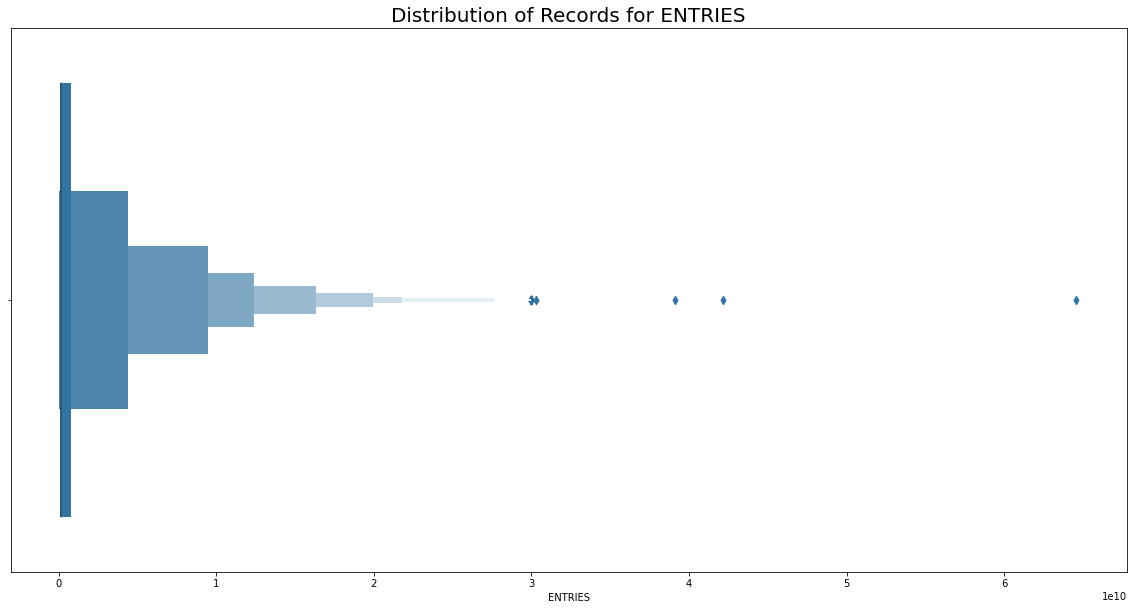

In [14]:
#check the distribution of records for entries

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,10))
g = sns.boxenplot(x='ENTRIES', data=stations_df)
plt.title("Distribution of Records for ENTRIES", fontsize=20);

Drop outliers

In [15]:
#drop everything greater than 2.75 x 10^(10)
stations_df = stations_df[stations_df.ENTRIES<=27500000000]

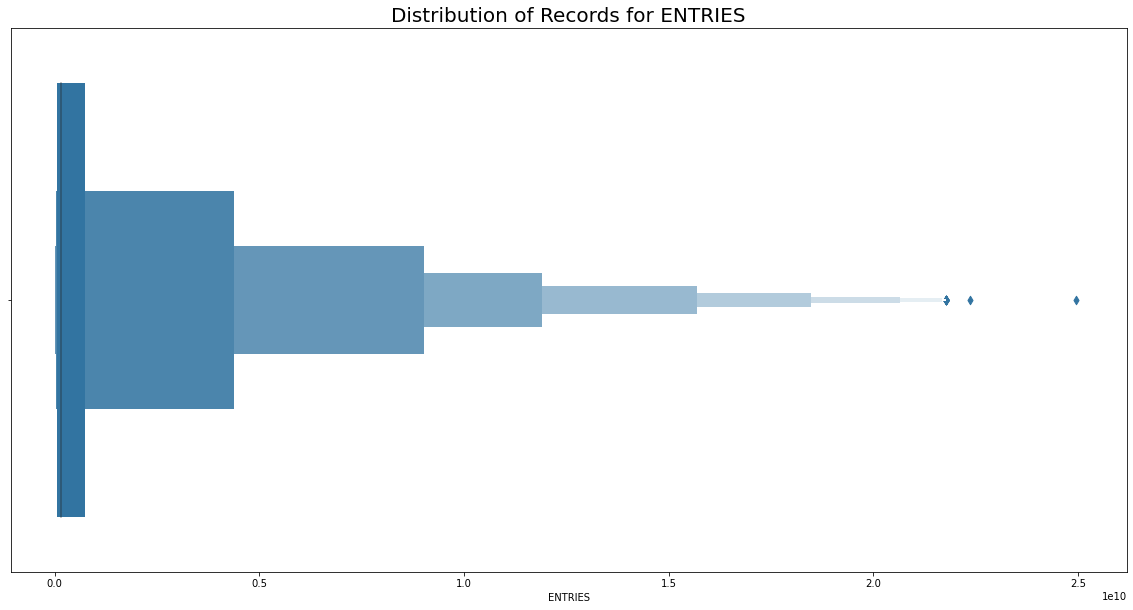

In [16]:
#check the distribution now

plt.figure(figsize=(20,10))
g = sns.boxenplot(x='ENTRIES', data=stations_df)
plt.title("Distribution of Records for ENTRIES", fontsize=20);

In [17]:
#create two new columns that are the previous day with associated 
#number of entries

stations_df[['Previous_date', 'Previous_Entries']] = (stations_df.groupby(["C/A", "UNIT", "STATION", "LINENAME"])["DATE", "ENTRIES"].apply(lambda grp: grp.shift(1)))

<ipython-input-17-7a3caab60f5f>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  stations_df[['Previous_date', 'Previous_Entries']] = (stations_df.groupby(["C/A", "UNIT", "STATION", "LINENAME"])["DATE", "ENTRIES"].apply(lambda grp: grp.shift(1)))


In [18]:
stations_df.head()

,C/A,UNIT,STATION,LINENAME,DATE,ENTRIES,EXITS,Previous_date,Previous_Entries
0,A002,R051,59 ST,NQR456W,08/29/2020,353663977,198126524,NaN,NaN
1,A002,R051,59 ST,NQR456W,08/30/2020,353674428,198135110,08/29/2020,353663977.0
2,A002,R051,59 ST,NQR456W,08/31/2020,353686433,198148360,08/30/2020,353674428.0
3,A002,R051,59 ST,NQR456W,09/01/2020,353707933,198166598,08/31/2020,353686433.0
4,A002,R051,59 ST,NQR456W,09/02/2020,353730492,198185494,09/01/2020,353707933.0


In [19]:
#drop the first row associated with each new station in order to 
# not combine data for different turnstiles

stations_df.dropna(subset = ['Previous_date'], axis = 0, inplace = True)

In [20]:
stations_df.head()

,C/A,UNIT,STATION,LINENAME,DATE,ENTRIES,EXITS,Previous_date,Previous_Entries
1,A002,R051,59 ST,NQR456W,08/30/2020,353674428,198135110,08/29/2020,353663977.0
2,A002,R051,59 ST,NQR456W,08/31/2020,353686433,198148360,08/30/2020,353674428.0
3,A002,R051,59 ST,NQR456W,09/01/2020,353707933,198166598,08/31/2020,353686433.0
4,A002,R051,59 ST,NQR456W,09/02/2020,353730492,198185494,09/01/2020,353707933.0
5,A002,R051,59 ST,NQR456W,09/03/2020,353753348,198204420,09/02/2020,353730492.0


In [21]:
#check, is the count actually increasing each day ?
# i.e., we should have count(yesterday) < count(today)
# but it looks like that's not the case

counter_mask = (stations_df['ENTRIES'] < stations_df['Previous_Entries'])
stations_df[counter_mask]

,C/A,UNIT,STATION,LINENAME,DATE,ENTRIES,EXITS,Previous_date,Previous_Entries
59,A007,R079,5 AV/59 ST,NQRW,09/15/2020,753398109,34731169,09/14/2020,1.130088e+09
77,A010,R080,57 ST-7 AV,NQRW,09/12/2020,375562005,140323051,09/11/2020,3.975106e+08
111,A013,R081,49 ST,NQRW,09/04/2020,152602116,307887908,09/03/2020,1.780288e+08
150,A015,R081,49 ST,NQRW,09/01/2020,198702519,110010218,08/31/2020,2.117487e+08
232,A025,R023,34 ST-HERALD SQ,BDFMNQRW,08/30/2020,7909459657,11414629126,08/29/2020,7.910489e+09
...,...,...,...,...,...,...,...,...,...
15551,R727,R430,PELHAM PKWY,5,09/16/2020,2220940437,969075163,09/15/2020,2.658626e+09
15620,S101,R070,ST. GEORGE,1,09/01/2020,109305378,89976,08/31/2020,1.215648e+08
15631,S101,R070,ST. GEORGE,1,09/12/2020,101372921,79540,09/11/2020,1.216425e+08
15670,S102,R165,TOMPKINSVILLE,1,09/09/2020,7542070,209631,09/08/2020,1.508286e+07


In [22]:
#how many tursntiles have this issue?
stations_df[counter_mask].groupby(["C/A", "UNIT", "STATION", "LINENAME"]).size()


C/A    UNIT  STATION          LINENAME
A007   R079  5 AV/59 ST       NQRW        1
A010   R080  57 ST-7 AV       NQRW        1
A013   R081  49 ST            NQRW        1
A015   R081  49 ST            NQRW        1
A025   R023  34 ST-HERALD SQ  BDFMNQRW    4
                                         ..
R641   R210  BEVERLY RD       25          1
R727   R430  PELHAM PKWY      5           2
S101   R070  ST. GEORGE       1           2
S102   R165  TOMPKINSVILLE    1           1
TRAM1  R468  RIT-MANHATTAN    R           1
Length: 352, dtype: int64

In [ ]:
# get the positive difference between days, and reset the counter manually if it is too 
# high

def daily_count2(row, max_count):
    count = row['ENTRIES'] - row['Previous_Entries']
    
    if count < 0:
        count *= -1
        
    if count > max_count:
        print(row["ENTRIES"], row["Previous_Entries"])
        count = min(row["ENTRIES"], row["Previous_Entries"])
        
    if count > max_count:
        return 0
    return count

stations_df['Daily_Entries'] = stations_df.apply(daily_count2, axis=1, max_count=10000)


In [24]:
stations_df.head()

,C/A,UNIT,STATION,LINENAME,DATE,ENTRIES,EXITS,Previous_date,Previous_Entries,Daily_Entries
1,A002,R051,59 ST,NQR456W,08/30/2020,353674428,198135110,08/29/2020,353663977.0,0.0
2,A002,R051,59 ST,NQR456W,08/31/2020,353686433,198148360,08/30/2020,353674428.0,0.0
3,A002,R051,59 ST,NQR456W,09/01/2020,353707933,198166598,08/31/2020,353686433.0,0.0
4,A002,R051,59 ST,NQR456W,09/02/2020,353730492,198185494,09/01/2020,353707933.0,0.0
5,A002,R051,59 ST,NQR456W,09/03/2020,353753348,198204420,09/02/2020,353730492.0,0.0


In [25]:
stations_df.nlargest(10, 'Daily_Entries')

,C/A,UNIT,STATION,LINENAME,DATE,ENTRIES,EXITS,Previous_date,Previous_Entries,Daily_Entries
2405,E013,R373,20 AV,D,09/14/2020,56959985,32353862,09/13/2020,56949986.0,9999.0
13420,R329,R362,ALLERTON AV,25,09/05/2020,136907708,13604945,09/04/2020,136897709.0,9999.0
8237,N525,R142,DELANCEY/ESSEX,FJMZ,08/31/2020,169984384,146113714,08/30/2020,169974386.0,9998.0
3578,J031,R006,WOODHAVEN BLVD,JZ,09/11/2020,72565561,63024911,09/10/2020,72555564.0,9997.0
8223,N523,R300,2 AV,F,09/07/2020,284659598,322297317,09/06/2020,284649601.0,9997.0
4421,N043,R186,86 ST,BC,09/14/2020,156775266,76273368,09/13/2020,156765272.0,9994.0
14303,R514,R094,ASTORIA BLVD,NQW,09/06/2020,402622145,4097724567,09/05/2020,402612151.0,9994.0
2288,E004,R234,50 ST,D,09/02/2020,79790843,76958265,09/01/2020,79780850.0,9993.0
11911,R231A,R176,33 ST,6,09/02/2020,97652997,54688541,09/01/2020,97643004.0,9993.0
12809,R291,R183,BEDFORD PK BLVD,4,09/03/2020,21005606,9605214,09/02/2020,20995614.0,9992.0


In [26]:
#drop the zero daily entres
stations_df = stations_df[stations_df.Daily_Entries !=0]

In [39]:
#add the combination of station and line name
stations_df['STATION_LINE'] = stations_df['STATION'] + ' ' + stations_df['LINENAME']
stations_df.head()

,C/A,UNIT,STATION,LINENAME,DATE,ENTRIES,EXITS,Previous_date,Previous_Entries,Daily_Entries,STATION_LINE
22,A006,R079,5 AV/59 ST,NQRW,08/30/2020,126851096,178578594,08/29/2020,126843178.0,7918.0,5 AV/59 ST NQRW
30,A006,R079,5 AV/59 ST,NQRW,09/07/2020,126965334,178681917,09/06/2020,126955642.0,9692.0,5 AV/59 ST NQRW
43,A007,R079,5 AV/59 ST,NQRW,08/30/2020,753319756,34654540,08/29/2020,753316532.0,3224.0,5 AV/59 ST NQRW
44,A007,R079,5 AV/59 ST,NQRW,08/31/2020,753324590,34659634,08/30/2020,753319756.0,4834.0,5 AV/59 ST NQRW
45,A007,R079,5 AV/59 ST,NQRW,09/01/2020,753330033,34664028,08/31/2020,753324590.0,5443.0,5 AV/59 ST NQRW


In [28]:
stations_df.describe()

,ENTRIES,EXITS,Previous_Entries,Daily_Entries
count,8.102000e+03,8.102000e+03,8.102000e+03,8102.000000
mean,1.437794e+09,1.142572e+09,1.437789e+09,5094.578005
std,3.410769e+09,3.111816e+09,3.410769e+09,2666.292806
min,8.620000e+03,2.284300e+04,8.592000e+03,1.000000
25%,4.712075e+07,2.830340e+07,4.711577e+07,2893.500000
50%,9.902413e+07,7.156157e+07,9.901675e+07,5142.000000
75%,6.673284e+08,1.766392e+08,6.673214e+08,7253.750000
max,2.177012e+10,2.782090e+10,2.177011e+10,9999.000000


## Some Visuals

Just getting a feel for some of the data visuals. The rest are in another notebook

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

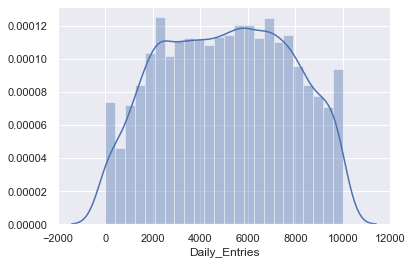

In [30]:
sns.distplot(stations_df['Daily_Entries']
             [stations_df['Daily_Entries'] < 50000])

In [34]:
stations_daily = (stations_df.groupby(['STATION', 'LINENAME', 'STATION_LINE', 'DATE'])['Daily_Entries'].sum().reset_index())

stations_daily.head(10)

,STATION,LINENAME,STATION_LINE,DATE,Daily_Entries
0,1 AV,L,1 AV L,08/30/2020,7808.0
1,1 AV,L,1 AV L,08/31/2020,13014.0
2,1 AV,L,1 AV L,09/01/2020,6215.0
3,1 AV,L,1 AV L,09/02/2020,6635.0
4,1 AV,L,1 AV L,09/03/2020,6729.0
5,1 AV,L,1 AV L,09/04/2020,7043.0
6,1 AV,L,1 AV L,09/05/2020,5960.0
7,1 AV,L,1 AV L,09/06/2020,11913.0
8,1 AV,L,1 AV L,09/07/2020,9364.0
9,1 AV,L,1 AV L,09/08/2020,12271.0


In [35]:
top10_stations = \
    (stations_daily.groupby(['STATION_LINE'])['Daily_Entries'].sum()
                   .reset_index()
                   .sort_values(by='Daily_Entries',ascending=False) 
                   .STATION_LINE.head(10))
top10_stations.head(10)

84     34 ST-PENN STA ACE
269    FULTON ST 2345ACJZ
22           14 ST FLM123
78                33 ST 6
96             49 ST NQRW
234      CORTLANDT ST RNW
308     KINGSBRIDGE RD BD
404      VERNON-JACKSON 7
408            WALL ST 23
94               46 ST MR
Name: STATION_LINE, dtype: object

In [36]:
stations_daily_top10 = stations_df[stations_df['STATION_LINE'].isin(top10_stations)]
stations_daily_top10

,C/A,UNIT,STATION,LINENAME,DATE,ENTRIES,EXITS,Previous_date,Previous_Entries,Daily_Entries,STATION_LINE
106,A013,R081,49 ST,NQRW,08/30/2020,152575761,307855750,08/29/2020,152572931.0,2830.0,49 ST NQRW
107,A013,R081,49 ST,NQRW,08/31/2020,152578932,307861117,08/30/2020,152575761.0,3171.0,49 ST NQRW
108,A013,R081,49 ST,NQRW,09/01/2020,152584490,307867719,08/31/2020,152578932.0,5558.0,49 ST NQRW
109,A013,R081,49 ST,NQRW,09/02/2020,152590227,307874563,09/01/2020,152584490.0,5737.0,49 ST NQRW
112,A013,R081,49 ST,NQRW,09/05/2020,152607649,307894332,09/04/2020,152602116.0,5533.0,49 ST NQRW
...,...,...,...,...,...,...,...,...,...,...,...
14143,R506,R276,VERNON-JACKSON,7,09/14/2020,44280125,903021,09/13/2020,44277229.0,2896.0,VERNON-JACKSON 7
14144,R506,R276,VERNON-JACKSON,7,09/15/2020,44284620,903670,09/14/2020,44280125.0,4495.0,VERNON-JACKSON 7
14145,R506,R276,VERNON-JACKSON,7,09/16/2020,44289536,904299,09/15/2020,44284620.0,4916.0,VERNON-JACKSON 7
14146,R506,R276,VERNON-JACKSON,7,09/17/2020,44294522,904956,09/16/2020,44289536.0,4986.0,VERNON-JACKSON 7


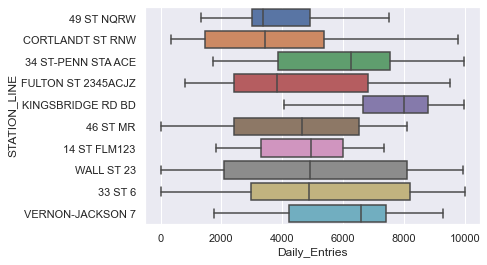

In [37]:
sns.boxplot('Daily_Entries', 'STATION_LINE',data=stations_daily_top10)

get top 25 stations

In [38]:
top25_stations = \
    (stations_daily.groupby(['STATION_LINE'])['Daily_Entries'].sum()
                   .reset_index()
                   .sort_values(by='Daily_Entries',ascending=False) 
                   .STATION_LINE.head(25))
top25_stations

84     34 ST-PENN STA ACE
269    FULTON ST 2345ACJZ
22           14 ST FLM123
78                33 ST 6
96             49 ST NQRW
234      CORTLANDT ST RNW
308     KINGSBRIDGE RD BD
404      VERNON-JACKSON 7
408            WALL ST 23
94               46 ST MR
64                23 ST 6
104               51 ST 6
13              125 ST 23
138               86 ST 1
50               181 ST A
41              170 ST BD
115       66 ST-LINCOLN 1
286          HOUSTON ST 1
268     FT HAMILTON PKY N
43         174-175 STS BD
185     BEDFORD-NOSTRAN G
333     MYRTLE-WILLOUGH G
376       ROCKAWAY BLVD A
74              28 ST NRW
216     CATHEDRAL PKWY BC
Name: STATION_LINE, dtype: object

In [40]:
stations_daily_top25 = stations_df[stations_df['STATION_LINE'].isin(top25_stations)]


In [41]:
stations_daily_top25.head()

,C/A,UNIT,STATION,LINENAME,DATE,ENTRIES,EXITS,Previous_date,Previous_Entries,Daily_Entries,STATION_LINE
106,A013,R081,49 ST,NQRW,08/30/2020,152575761,307855750,08/29/2020,152572931.0,2830.0,49 ST NQRW
107,A013,R081,49 ST,NQRW,08/31/2020,152578932,307861117,08/30/2020,152575761.0,3171.0,49 ST NQRW
108,A013,R081,49 ST,NQRW,09/01/2020,152584490,307867719,08/31/2020,152578932.0,5558.0,49 ST NQRW
109,A013,R081,49 ST,NQRW,09/02/2020,152590227,307874563,09/01/2020,152584490.0,5737.0,49 ST NQRW
112,A013,R081,49 ST,NQRW,09/05/2020,152607649,307894332,09/04/2020,152602116.0,5533.0,49 ST NQRW


In [ ]:
#pickle our top 25 stations data
stations_daily_top25.to_pickle('stations_daily_top25.pkl')

### Some sanity checks
checking the values to make sure we don't have anything crazy
I would assume that stations like time square would be included in the busiest, so why wasn't it?

In [42]:
stations_daily[stations_daily['STATION'] == 'TIMES SQ-42 ST'].max()

STATION                       TIMES SQ-42 ST
LINENAME                        ACENQRS1237W
STATION_LINE     TIMES SQ-42 ST ACENQRS1237W
DATE                              09/14/2020
Daily_Entries                          17464
dtype: object

In [43]:
stations_daily[stations_daily['STATION_LINE'] == '34 ST-PENN STA ACE'].max()

#it seems penn station has way more entries, and Times Square doesn't have that many

STATION              34 ST-PENN STA
LINENAME                        ACE
STATION_LINE     34 ST-PENN STA ACE
DATE                     09/18/2020
Daily_Entries                 40040
dtype: object

At this point, I ran the same analyses on data from previous years. The analysis on previous years has consistent results across all years with the more popular stations I was expecting to see. The only difference in results was for this year, which is when our data is from. I am assuming the difference is due to covid's massive imapct on travel and tourism. The other analyses are in this repo under the branch 'Nedas_branch' in the folders labeled from 2017-2019 if interested.